In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df1=pd.read_csv('DHDS_cleaned.csv')
data=df1
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11238 entries, 0 to 11237
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     11238 non-null  int64  
 1   LocationAbbr             11238 non-null  object 
 2   LocationDesc             11238 non-null  object 
 3   Category                 11238 non-null  object 
 4   Indicator                11238 non-null  object 
 5   Response                 11238 non-null  object 
 6   Data_Value_Unit          11238 non-null  object 
 7   Data_Value_Type          11238 non-null  object 
 8   Data_Value               11238 non-null  float64
 9   Number                   11238 non-null  float64
 10  WeightedNumber           11238 non-null  float64
 11  StratificationCategory1  11238 non-null  object 
 12  Stratification1          11238 non-null  object 
 13  StratificationCategory2  11238 non-null  object 
 14  Stratification2       

In [3]:
print(data.describe())

               Year    Data_Value         Number  WeightedNumber  \
count  11238.000000  11238.000000   11238.000000    1.123800e+04   
mean    2018.559263     43.442380    1108.266195    6.303382e+05   
std        2.132482     28.225218    5790.526413    3.381437e+06   
min     2016.000000      0.700000       8.000000    4.390000e+02   
25%     2017.000000     19.808190     122.000000    4.327775e+04   
50%     2018.000000     38.200000     344.000000    1.486760e+05   
75%     2020.000000     67.500000     860.946351    4.435572e+05   
max     2022.000000     99.900000  236045.000000    1.584285e+08   

          Longitude      Latitude  
count  11238.000000  11238.000000  
mean     -83.250749     50.113880  
std       11.098821      8.492347  
min     -157.857749     21.304850  
25%      -88.661065     43.429034  
50%      -82.018530     49.845531  
75%      -75.577741     57.288751  
max      -68.985031     64.845080  


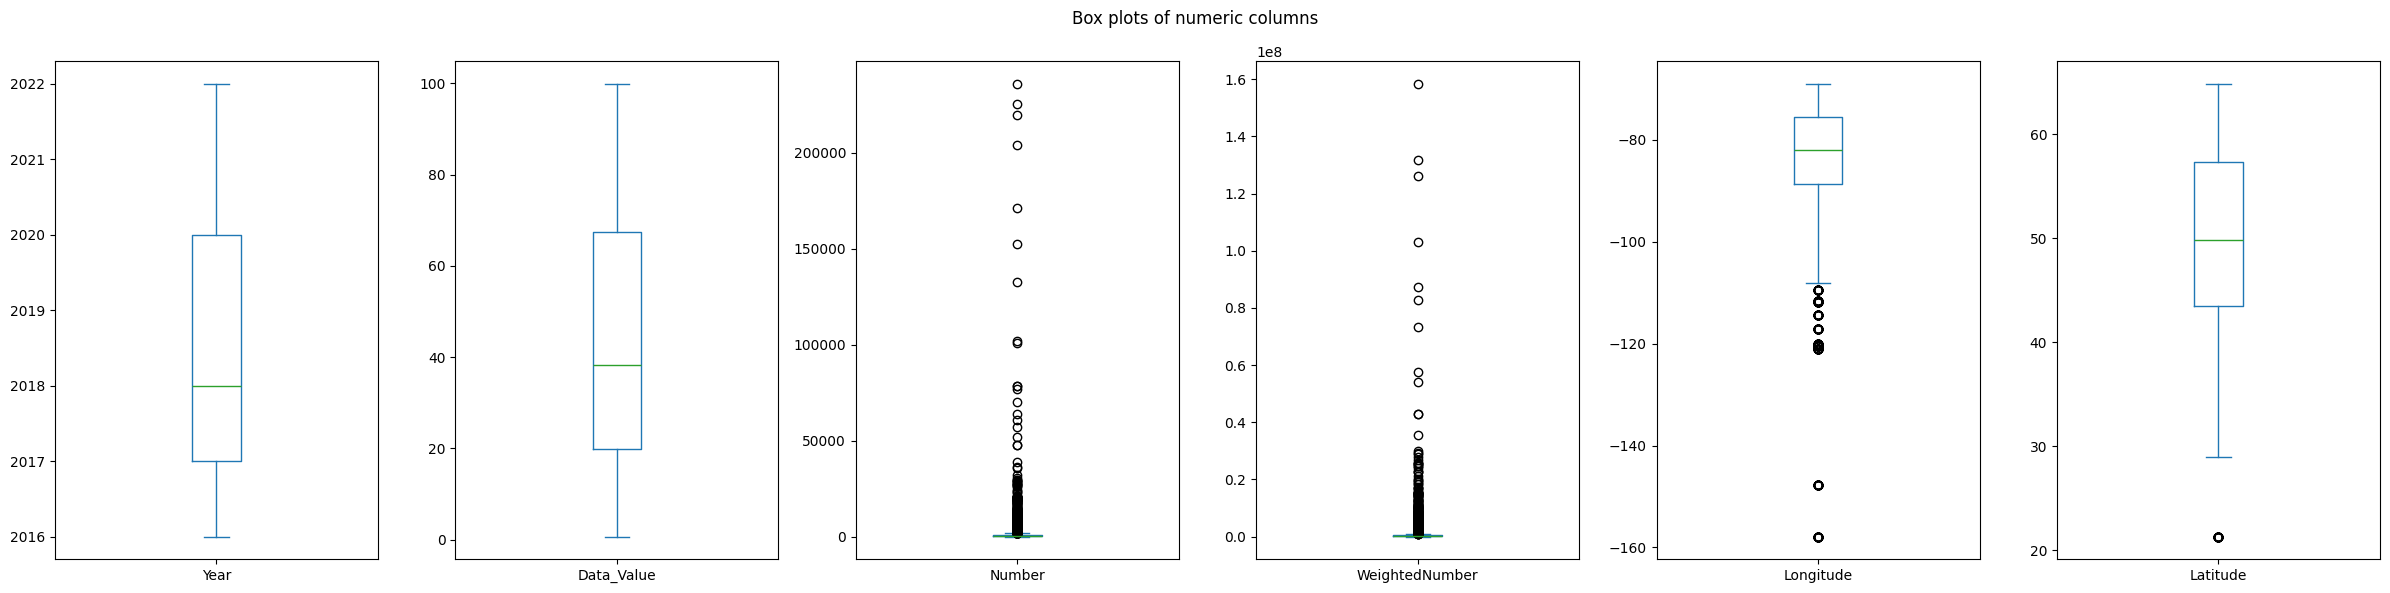

In [4]:
# create box plots for numeric columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
if not num_cols:
    print("No numeric columns to plot.")
else:
    ax = data[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)),
                            figsize=(4 * max(1, len(num_cols)), 6), sharey=False)
    plt.suptitle('Box plots of numeric columns')
    plt.tight_layout()
    plt.show()

                skew_original  skew_signed_log1p
column                                          
Data_Value           0.366830          -0.831026
Number              27.178163           0.235858
WeightedNumber      27.149530           0.009090


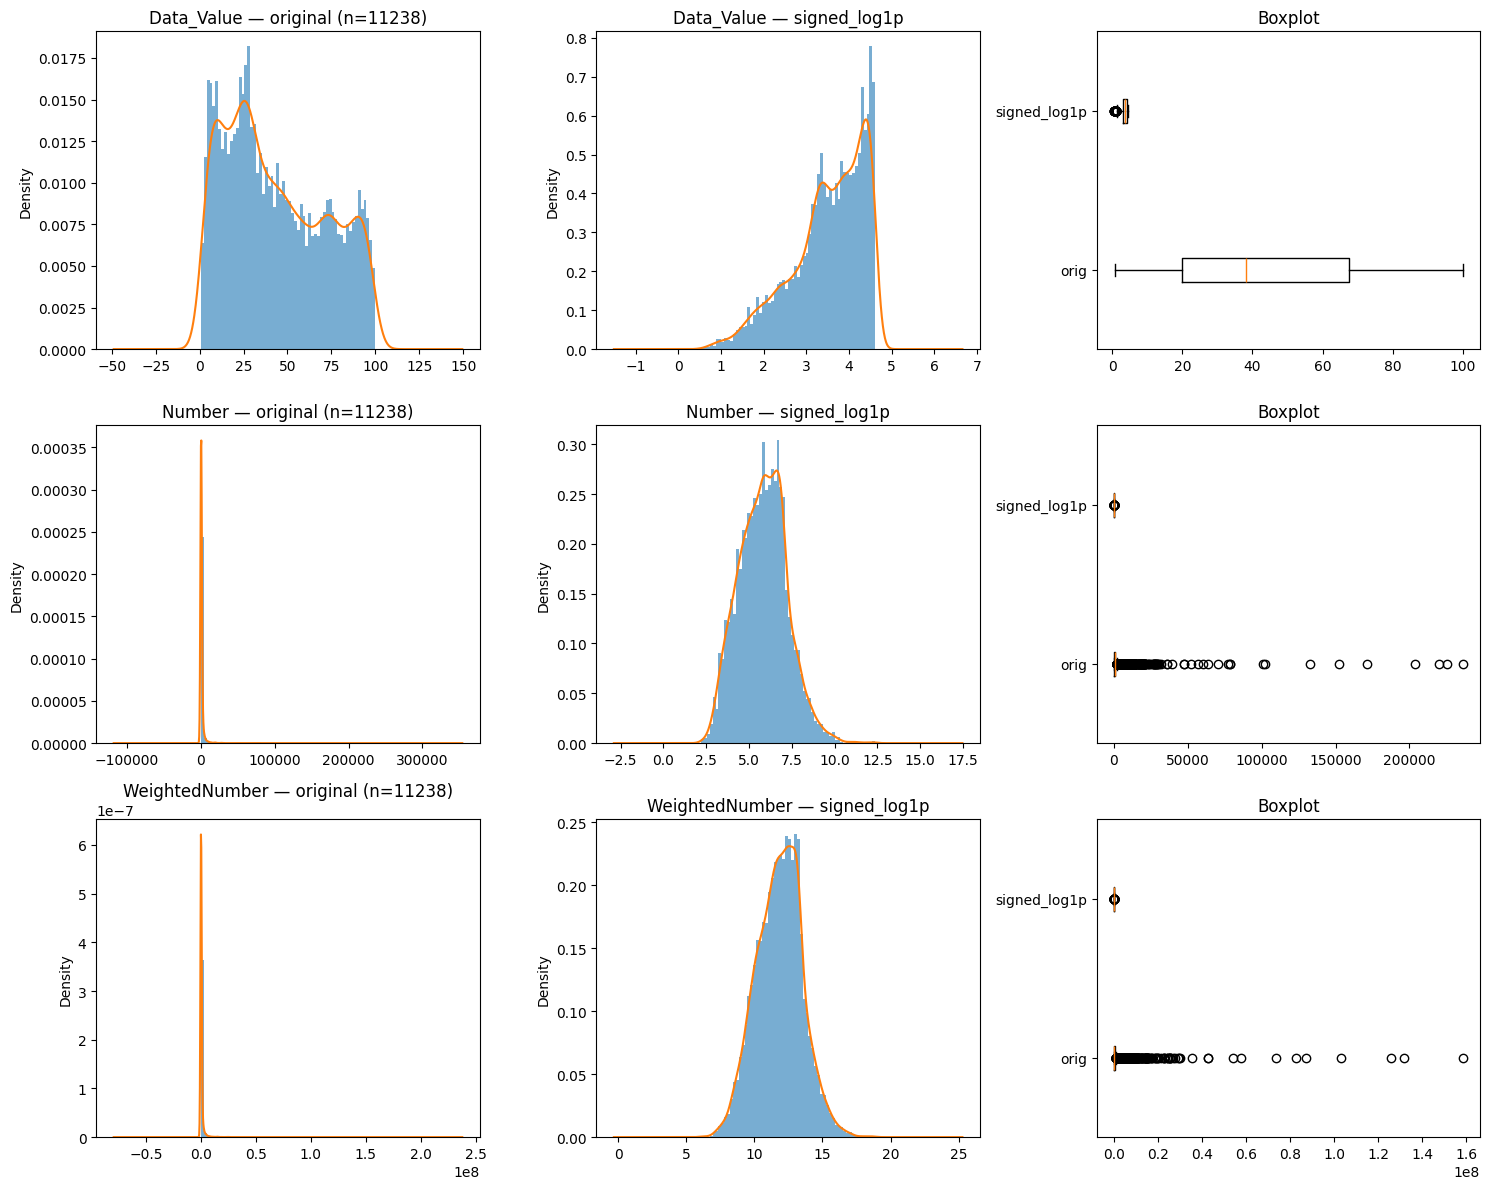

In [5]:
# Visual checks for skewness for numeric columns in num_cols (exclude Longitude & Latitude)
def signed_log1p(s):
    return np.sign(s) * np.log1p(np.abs(s))

cols = [c for c in num_cols if c not in ('Year','Longitude', 'Latitude')]
n = len(cols)
if n == 0:
    print("No numeric columns to check (after excluding Longitude/Latitude).")
else:
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, 4 * n))
    if n == 1:
        axes = axes.reshape(1, 3)

    skew_stats = []
    for i, col in enumerate(cols):
        s = data[col].dropna()
        # original histogram + KDE
        ax0 = axes[i, 0]
        s.plot(kind='hist', bins=60, density=True, alpha=0.6, ax=ax0)
        try:
            s.plot(kind='kde', ax=ax0)
        except Exception:
            pass
        ax0.set_title(f'{col} — original (n={len(s)})')

        # signed log1p transform and its histogram + KDE
        s_tr = signed_log1p(s)
        ax1 = axes[i, 1]
        pd.Series(s_tr).plot(kind='hist', bins=60, density=True, alpha=0.6, ax=ax1)
        try:
            pd.Series(s_tr).plot(kind='kde', ax=ax1)
        except Exception:
            pass
        ax1.set_title(f'{col} — signed_log1p')

        # boxplots (original vs transformed)
        ax2 = axes[i, 2]
        ax2.boxplot([s.values, pd.Series(s_tr).values], tick_labels=['orig', 'signed_log1p'], vert=False)
        ax2.set_title('Boxplot')

        skew_stats.append((col, float(s.skew()), float(pd.Series(s_tr).skew())))

    plt.tight_layout()
    skew_df = pd.DataFrame(skew_stats, columns=['column', 'skew_original', 'skew_signed_log1p']).set_index('column')
    print(skew_df)
    plt.show()

In [6]:
# add signed_log1p transformed columns for the inspected numeric cols
for col in cols:
    data[col] = signed_log1p(data[col])


In [7]:
print(data.describe())
print(data.info())
print(df1.info())

               Year    Data_Value        Number  WeightedNumber     Longitude  \
count  11238.000000  11238.000000  11238.000000    11238.000000  11238.000000   
mean    2018.559263      3.513352      5.825101       11.842390    -83.250749   
std        2.132482      0.845594      1.405290        1.685564     11.098821   
min     2016.000000      0.530628      2.197225        6.086775   -157.857749   
25%     2017.000000      3.035346      4.812184       10.675417    -88.661065   
50%     2018.000000      3.668677      5.843544       11.909531    -82.018530   
75%     2020.000000      4.226834      6.759193       13.002584    -75.577741   
max     2022.000000      4.614130     12.371782       18.880814    -68.985031   

           Latitude  
count  11238.000000  
mean      50.113880  
std        8.492347  
min       21.304850  
25%       43.429034  
50%       49.845531  
75%       57.288751  
max       64.845080  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11238 entries, 0 to 11

In [8]:
out_path = 'DHDS_transformed.csv'
data.to_csv(out_path, index=False)
print(f"Data saved to {out_path}")

Data saved to DHDS_transformed.csv
